In [49]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import textstat
import emoji
import re
from pymer4.utils import get_resource_path
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats


In [50]:
# Define the base path to your CSV files
base_path = '/Users/sandervanduin/Desktop/HVA weekly /Digitial Marketing Strategy/DMSteam9'
#base_path = '/Users/owenalberts/Desktop/Master Digital Driven Business/Digital marketing strategy/DMSteam9'

# Explicitly load each CSV file into its own DataFrame
df1 = pd.read_csv(os.path.join(base_path, 'Themeparcs I.csv'), on_bad_lines='skip', delimiter=';')
df2 = pd.read_csv(os.path.join(base_path, 'Themeparcs II.csv'), on_bad_lines='skip', delimiter=';')
df3 = pd.read_csv(os.path.join(base_path, 'Themeparcs III.csv'), on_bad_lines='skip', delimiter=';')
df4 = pd.read_csv(os.path.join(base_path, 'Themeparcs IV.csv'), on_bad_lines='skip', delimiter=';')

# Example operation: print the first few rows of the DataFrame
merged_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
print("First few rows of Merged Themeparcs :")
merged_df.head(5)

First few rows of Merged Themeparcs :


,Date,Profile,Message,Number of Reactions,Number of Shares,Number of Comments (primary),Number of Shares.1,Comments per post,Comments on posts by fans,Post interaction rate,Engagement,Number of Likes,Link-posts,Picture Posts,Video-posts,Profile-ID,Post-ID,Link
0,12/31/23 9:40 PM,Wild Adventures Theme Park,🎟️🚨 Today's the FINAL day to use your 2023 Sea...,16.0,NaN,2.0,2.0,2.0,2.0,"1,09E+12","1090000000000,00",13.0,NaN,1.0,NaN,84679583132,84679583132_770120045161180,https://www.facebook.com/617429960430190/posts...
1,12/31/23 8:01 PM,Fun Spot America,See you next year! 😉 Don’t miss...,38.0,NaN,1.0,2.0,1.0,1.0,"4,17E+11","417000000000,00",33.0,NaN,NaN,NaN,"1,84E+11",184020466977_767286052104076,https://www.facebook.com/653224623510220/posts...
2,12/31/23 7:30 PM,Fun Spot America,Don't miss our HUGE firework display ! 🥳\n\n#f...,23.0,NaN,2.0,3.0,2.0,2.0,"2,85E+11","285000000000,00",21.0,NaN,NaN,1.0,"1,84E+11",184020466977_767267948772553,https://www.facebook.com/653224623510220/posts...
3,12/31/23 7:00 PM,Disneyland Paris,Fijne jaarwisseling! 🥂🎉\nEn tot volgend jaar 😉,646.0,NaN,52.0,12.0,56.0,56.0,"1,36E+11","136000000000,00",478.0,NaN,1.0,NaN,"6,52E+14",652389081615295_775974521237956,https://www.facebook.com/724434559725286/posts...
4,12/31/23 7:00 PM,Silverwood Theme Park,It's the last day of our New Year's Sale! Save...,17.0,NaN,2.0,0.0,2.0,2.0,"4,96E+11","496000000000,00",16.0,NaN,NaN,1.0,"7,63E+14",762701550509617_678920137770716,https://www.facebook.com/562559642740100/posts...


In [51]:
# Counts of unique values for a specific column
merged_df['Profile'].value_counts().head(5)

Profile
Wild Adventures Theme Park    955
Happy Hollow Park & Zoo       627
Cedar Point                   478
Walt Disney Studios (US)      450
Playland                      446
Name: count, dtype: int64

In [52]:
# Sum up the number of reactions for each profile
reactions_sum = merged_df.groupby(['Profile', 'Profile-ID'])['Number of Reactions'].sum().reset_index()

# Sort profiles by the number of reactions in descending order and get the top 100
top_profiles = reactions_sum.sort_values('Number of Reactions', ascending=False).head(100)

top_profiles.head(10)

,Profile,Profile-ID,Number of Reactions
54,Walt Disney Animation Studios,23245476854,1745666.0
55,Walt Disney Studios (US),"1,11E+14",1343887.0
13,Disneyland,11081890741,540414.0
52,Universal Orlando Resort (US),90867402851,434662.0
56,Walt Disney World,"1,56E+11",426506.0
4,Busch Gardens Tampa Bay,68181225238,289953.0
11,Cedar Point,10625691462,256408.0
53,Universal Studios Hollywood,61784580148,236426.0
34,Santa Cruz Beach Boardwalk,40035168377,222131.0
22,Hersheypark,16994689356,209908.0


In [53]:
# Fill NaN values with 0 for calculation
merged_df['Number of Shares'] = merged_df['Number of Shares'].fillna(0)
# merged_df['Number of Shares.1'] = merged_df['Number of Shares.1'].fillna(0)

# Calculate total shares by summing both shares columns
merged_df['total_shares'] = merged_df['Number of Shares'] + merged_df['Number of Shares.1']

# Now group by 'Profile' and sum the 'Total Shares', and then sort the sums in ascending order
shares_per_profile = merged_df.groupby('Profile')['total_shares'].sum().sort_values(ascending=False)

shares_per_profile.head(5)

Profile
Walt Disney Animation Studios    227392.0
Walt Disney Studios (US)         118026.0
Universal Orlando Resort (US)     76962.0
Walt Disney World                 59715.0
Disneyland                        51015.0
Name: total_shares, dtype: float64

## Creating our dependent variable

Unweighted engagement score ---> consisting of:
- `"Number of reactions"`
- `"total_shares"`
- `"Number of Comments (primary)"`
- `"Number of Likes"`

In [54]:
# Function to calculate the average excluding zeros, unless all values are zero
def calculate_unweighted_average(row):
    values = [row['Number of Reactions'], row['total_shares'], row['Number of Comments (primary)'], row['Number of Likes']]
    # Remove zeros but only if not all values are zeros
    filtered_values = [value for value in values if value != 0] or values
    return np.mean(filtered_values)
 
# Apply the function to each row in the DataFrame
merged_df['Unweighted_Engagement_Score'] = merged_df.apply(calculate_unweighted_average, axis=1)
 
# Display the first few rows to verify the changes
merged_df[['Date', 'Profile', 'Message', 'Number of Reactions', 'total_shares', 'Number of Comments (primary)', 'Number of Likes', 'Unweighted_Engagement_Score']].head()

,Date,Profile,Message,Number of Reactions,total_shares,Number of Comments (primary),Number of Likes,Unweighted_Engagement_Score
0,12/31/23 9:40 PM,Wild Adventures Theme Park,🎟️🚨 Today's the FINAL day to use your 2023 Sea...,16.0,2.0,2.0,13.0,8.250000
1,12/31/23 8:01 PM,Fun Spot America,See you next year! 😉 Don’t miss...,38.0,2.0,1.0,33.0,18.500000
2,12/31/23 7:30 PM,Fun Spot America,Don't miss our HUGE firework display ! 🥳\n\n#f...,23.0,3.0,2.0,21.0,12.250000
3,12/31/23 7:00 PM,Disneyland Paris,Fijne jaarwisseling! 🥂🎉\nEn tot volgend jaar 😉,646.0,12.0,52.0,478.0,297.000000
4,12/31/23 7:00 PM,Silverwood Theme Park,It's the last day of our New Year's Sale! Save...,17.0,0.0,2.0,16.0,11.666667


### Sub Question 1

##### "What content features (e.g., visual elements, text, use of hashtags) are associated with higher engagement rates in theme park brand posts on Facebook?"

`Making new features`
- `Number of hashtags`
- `Text readability`
- `Readability score`
- `Emoji count`


In [55]:
# Making new features out of "Message" column
# -->  Count the number of hashtags in each message ----- Number of hashtags
# -->  Count the number of characters in each message ----- Text readability
# -->  Using Flesch Reading Ease formula ----- Readability score
# -->  Count the number of emojis in each message ----- Emoji count


# Count the number of characters in each message
merged_df['text_length'] = merged_df['Message'].apply(len)

# Count the number of hashtags in each message
merged_df['hashtag_count'] = merged_df['Message'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))

# What does the readability score mean?
# The Flesch Reading Ease formula will output a number from 0 to 100 - a higher score indicates easier readability.
merged_df['readability_score'] = merged_df['Message'].apply(textstat.flesch_reading_ease)

# Function to count the number of emojis in each post
def count_emojis(text):
    # Using the emoji library to count all emoji characters in the text
    return emoji.emoji_count(text)
# Apply the function to count emojis
merged_df['emoji_count'] = merged_df['Message'].apply(count_emojis)

# Print the first few rows of the DataFrame
merged_df[['Profile', 'Message', 'text_length', 'hashtag_count', 'readability_score', 'emoji_count', 'Unweighted_Engagement_Score']].head(5)

#merged_df to csv
#merged_df.to_csv('merged_df_test.csv', index=False)

,Profile,Message,text_length,hashtag_count,readability_score,emoji_count,Unweighted_Engagement_Score
0,Wild Adventures Theme Park,🎟️🚨 Today's the FINAL day to use your 2023 Sea...,337,0,74.69,7,8.250000
1,Fun Spot America,See you next year! 😉 Don’t miss...,141,4,87.72,3,18.500000
2,Fun Spot America,Don't miss our HUGE firework display ! 🥳\n\n#f...,128,8,38.99,1,12.250000
3,Disneyland Paris,Fijne jaarwisseling! 🥂🎉\nEn tot volgend jaar 😉,45,0,48.47,3,297.000000
4,Silverwood Theme Park,It's the last day of our New Year's Sale! Save...,227,0,83.36,0,11.666667


In [56]:
# Filter out entries where 'Unweighted Engagement Score' is above 600 for outliers
filtered_df = merged_df[merged_df['Unweighted_Engagement_Score'] <= 600]

In [57]:
# Display basic statistics to understand the distribution and decide on binning thresholds
filtered_df[['text_length', 'hashtag_count', 'readability_score', 'emoji_count']].describe()

,text_length,hashtag_count,readability_score,emoji_count
count,14474.000000,14474.000000,14474.000000,14474.000000
mean,247.246926,1.401409,72.488312,1.452259
std,214.236459,4.872136,44.442346,1.745730
min,1.000000,0.000000,-1739.990000,0.000000
25%,113.000000,0.000000,56.930000,0.000000
50%,210.000000,0.000000,69.855000,1.000000
75%,313.000000,1.000000,81.630000,2.000000
max,4149.000000,37.000000,206.840000,21.000000


In [63]:
filtered_df = filtered_df.copy()

# Binning/Categorizing each variable
filtered_df['text_length_cat'] = pd.cut(filtered_df['text_length'], bins=[0, 108, 309, float('inf')], labels=['Short', 'Medium', 'Long'], right=False)
filtered_df['hashtag_count_cat'] = pd.cut(filtered_df['hashtag_count'], bins=[0, 1, 2, float('inf')], labels=['Few', 'Moderate', 'Many'], right=False)
filtered_df['readability_score_cat'] = pd.cut(filtered_df['readability_score'], bins=[-float('inf'), 56.96, 81.815, float('inf')], labels=['Hard', 'Moderate', 'Easy'], right=False)
filtered_df['emoji_count_cat'] = pd.cut(filtered_df['emoji_count'], bins=[0, 1, 2, float('inf')], labels=['Few', 'Moderate', 'Many'], right=False)

# Display the first few rows to verify the binning
display_columns = ['text_length', 'text_length_cat', 'hashtag_count', 'hashtag_count_cat', 'readability_score', 'readability_score_cat', 'emoji_count', 'emoji_count_cat', 'Unweighted_Engagement_Score']
display(filtered_df[display_columns].head(5))


,text_length,text_length_cat,hashtag_count,hashtag_count_cat,readability_score,readability_score_cat,emoji_count,emoji_count_cat,Unweighted_Engagement_Score
0,337,Long,0,Few,74.69,Moderate,7,Many,8.250000
1,141,Medium,4,Many,87.72,Easy,3,Many,18.500000
2,128,Medium,8,Many,38.99,Hard,1,Moderate,12.250000
3,45,Short,0,Few,48.47,Hard,3,Many,297.000000
4,227,Medium,0,Few,83.36,Easy,0,Few,11.666667


In [59]:
# count the number of entries in each bin
filtered_df['emoji_count_cat'].value_counts()

emoji_count_cat
Many        5693
Few         5590
Moderate    3191
Name: count, dtype: int64

## Q-Q
(quantile-quantile) plot helps visually assess if your data follows a certain distribution, such as a normal distribution. Points lying along the line indicate that the data are well-modeled by the distribution.

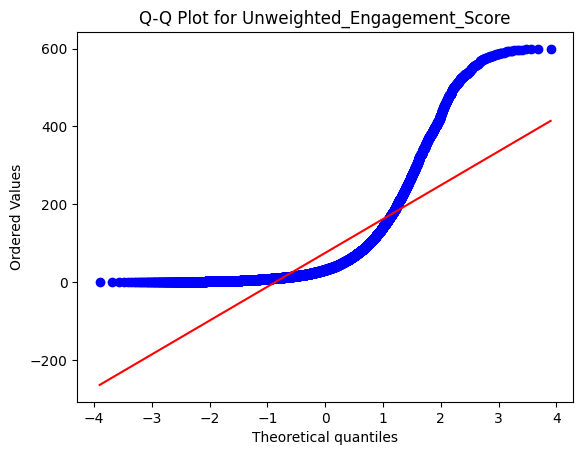

In [60]:
# Example for 'Unweighted_Engagement_Score'
data = filtered_df['Unweighted_Engagement_Score'].dropna()
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot for Unweighted_Engagement_Score')
plt.show()

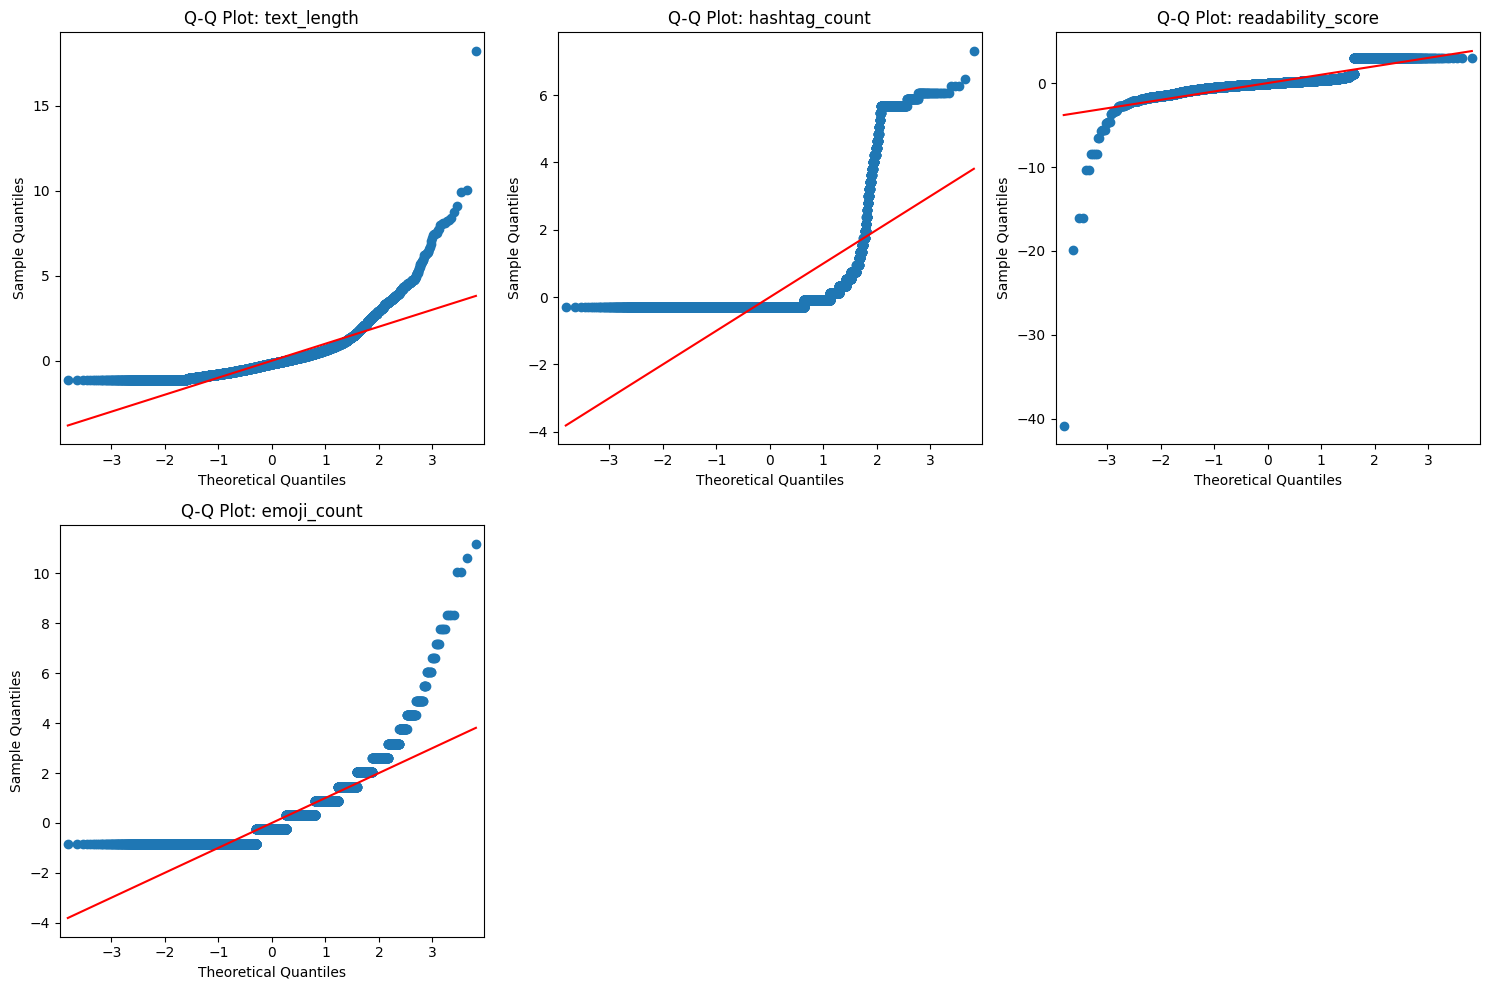

In [68]:
variables_to_test = ['text_length', 'hashtag_count', 'readability_score', 'emoji_count']

# Set up the matplotlib figure for Q-Q plot analysis of the updated variables
plt.figure(figsize=(15, 10))  # Adjusting figure size for visibility

# Create a Q-Q plot for each variable in 'variables_to_test'
for i, variable in enumerate(variables_to_test, 1):
    plt.subplot(2, 3, i)  # Arrange plots in 2 rows and 3 columns
    sm.qqplot(filtered_df[variable], line='s', fit=True, ax=plt.gca())  # Generate Q-Q plot for the variable
    plt.title(f'Q-Q Plot: {variable}')

# Adjust layout to prevent overlap and ensure all titles and axes are visible
plt.tight_layout()
plt.show()

In [70]:
from statsmodels.stats.diagnostic import lilliefors

for i, variable in enumerate(variables_to_test, 1):
    print(f"Variable: {variable}")
    stat, p_value = lilliefors(filtered_df[variable], dist='norm')
    print(f"Lilliefors test statistic: {stat}, p-value: {p_value}")
    print()


Variable: text_length
Lilliefors test statistic: 0.13109727469954868, p-value: 0.0009999999999998899

Variable: hashtag_count
Lilliefors test statistic: 0.4032886021791525, p-value: 0.0009999999999998899

Variable: readability_score
Lilliefors test statistic: 0.21607325951111245, p-value: 0.0009999999999998899

Variable: emoji_count
Lilliefors test statistic: 0.2088818815802071, p-value: 0.0009999999999998899



## Why all 0.0009999999999998899 ???

The p-value you're seeing, 0.0009999999999998899, is very likely a limitation of the lilliefors function in statsmodels for handling p-values below a certain threshold. This value essentially represents a p-value that's very small, below the granularity or precision the test can accurately report. It's telling you that the test statistic is significant enough to reject the null hypothesis of normality for each of these variables, but it doesn't provide a more precise p-value beyond this lower limit